<a href="https://colab.research.google.com/github/hasby-umutoniwabo/Colab/blob/main/Hasbiyallah_Umutoniwabo_PCA_Formative_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Formative Assignment: Advanced Linear Algebra (PCA)

In [1]:
!pip install kagglehub -q

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time, os, warnings
warnings.filterwarnings('ignore')
np.random.seed(42)

### Step 1: Load and Standardize the Data
Before applying PCA, we must standardize the dataset. Standardization ensures that all features have a mean of 0 and a standard deviation of 1, which is essential for PCA.
Fill in the code to standardize the dataset.

STRICTLY - Write code that implements standardization based on the image below

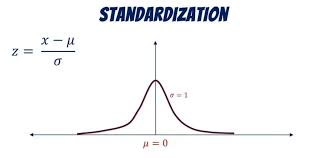


In [2]:
# Load dataset
import kagglehub
path = kagglehub.dataset_download("chirin/africa-economic-banking-and-systemic-crisis-data")
csv_file = os.path.join(path, "african_crises.csv")
df_raw = pd.read_csv(csv_file)
print(f"Shape: {df_raw.shape}")
print(f"Columns ({len(df_raw.columns)}): {list(df_raw.columns)}")

# Show non-numeric and missing
non_numeric_cols = df_raw.select_dtypes(include=['object']).columns.tolist()
print(f"\nNon-numeric columns ({len(non_numeric_cols)}): {non_numeric_cols}")
print(f"\nMissing values (raw): {df_raw.isnull().sum().sum()}")

# Introduce realistic missing values
df = df_raw.copy()
np.random.seed(42)
df.loc[np.random.random(len(df)) < 0.08, 'exch_usd'] = np.nan
df.loc[np.random.random(len(df)) < 0.12, 'inflation_annual_cpi'] = np.nan
df.loc[np.random.random(len(df)) < 0.05, 'gdp_weighted_default'] = np.nan
print(f"\nMissing values after introducing gaps: {df.isnull().sum().sum()}")
print(df.isnull().sum()[df.isnull().sum() > 0])

# Encode non-numeric columns
df['banking_crisis'] = df['banking_crisis'].map({'crisis': 1, 'no_crisis': 0})
countries = sorted(df['country'].unique())
df['country_encoded'] = df['country'].map({c: i for i, c in enumerate(countries)})
df_processed = df.drop(columns=['cc3', 'country'])

# Impute missing values with median
for col in df_processed.columns:
    n_missing = df_processed[col].isnull().sum()
    if n_missing > 0:
        median_val = df_processed[col].median()
        df_processed[col].fillna(median_val, inplace=True)
        print(f"  {col}: {n_missing} NaN -> filled with median = {median_val:.4f}")

print(f"\nFinal shape: {df_processed.shape}")
print(f"Missing after imputation: {df_processed.isnull().sum().sum()}")

# Prepare data array
data = df_processed.values.astype(float)
feature_names = list(df_processed.columns)
df_raw.head()

100%|██████████| 13.7k/13.7k [00:00<00:00, 18.4MB/s]

Extracting files...
Shape: (1059, 14)
Columns (14): ['case', 'cc3', 'country', 'year', 'systemic_crisis', 'exch_usd', 'domestic_debt_in_default', 'sovereign_external_debt_default', 'gdp_weighted_default', 'inflation_annual_cpi', 'independence', 'currency_crises', 'inflation_crises', 'banking_crisis']

Non-numeric columns (3): ['cc3', 'country', 'banking_crisis']

Missing values (raw): 0

Missing values after introducing gaps: 278
exch_usd                 89
gdp_weighted_default     58
inflation_annual_cpi    131
dtype: int64
  exch_usd: 89 NaN -> filled with median = 0.9015
  gdp_weighted_default: 58 NaN -> filled with median = 0.0000
  inflation_annual_cpi: 131 NaN -> filled with median = 5.8780

Final shape: (1059, 13)
Missing after imputation: 0


,case,cc3,country,year,systemic_crisis,exch_usd,domestic_debt_in_default,sovereign_external_debt_default,gdp_weighted_default,inflation_annual_cpi,independence,currency_crises,inflation_crises,banking_crisis
0,1,DZA,Algeria,1870,1,0.052264,0,0,0.0,3.441456,0,0,0,crisis
1,1,DZA,Algeria,1871,0,0.052798,0,0,0.0,14.149140,0,0,0,no_crisis
2,1,DZA,Algeria,1872,0,0.052274,0,0,0.0,-3.718593,0,0,0,no_crisis
3,1,DZA,Algeria,1873,0,0.051680,0,0,0.0,11.203897,0,0,0,no_crisis
4,1,DZA,Algeria,1874,0,0.051308,0,0,0.0,-3.848561,0,0,0,no_crisis


In [3]:
# Step 1: Load and Standardize the data (use of numpy only allowed)
standardized_data = (data - np.mean(data, axis=0)) / np.std(data, axis=0, ddof=0)
standardized_data[:5]

array([[-1.46165598, -2.91715048,  3.45175812, -0.37406308, -0.20321893,
        -0.42497295, -0.13119862, -0.03085367, -1.86235185, -0.37805817,
        -0.38547376,  3.20405328, -1.57145157],
       [-1.46165598, -2.88731291, -0.28970744, -0.37405814, -0.20321893,
        -0.42497295, -0.13119862, -0.03083782, -1.86235185, -0.37805817,
        -0.38547376, -0.31210467, -1.57145157],
       [-1.46165598, -2.85747534, -0.28970744, -0.37406299, -0.20321893,
        -0.42497295, -0.13119862, -0.03086427, -1.86235185, -0.37805817,
        -0.38547376, -0.31210467, -1.57145157],
       [-1.46165598, -2.82763778, -0.28970744, -0.37406849, -0.20321893,
        -0.42497295, -0.13119862, -0.03084218, -1.86235185, -0.37805817,
        -0.38547376, -0.31210467, -1.57145157],
       [-1.46165598, -2.79780021, -0.28970744, -0.37407193, -0.20321893,
        -0.42497295, -0.13119862, -0.03086447, -1.86235185, -0.37805817,
        -0.38547376, -0.31210467, -1.57145157]])

### Step 3: Calculate the Covariance Matrix
The covariance matrix helps us understand how the features are related to each other. It is a key component in PCA.

In [5]:
# Step 3: Calculate the Covariance Matrix
cov_matrix = (1 / standardized_data.shape[0]) * (standardized_data.T @ standardized_data)
cov_matrix

array([[ 1.00000000e+00,  1.15574379e-01,  1.09908067e-02,
        -2.18137366e-01,  1.28358123e-01, -3.92624144e-02,
        -1.71677258e-02,  4.47754612e-02,  2.18579917e-02,
         9.53387005e-02,  6.40544947e-03, -2.36522849e-02,
         9.90553403e-01],
       [ 1.15574379e-01,  1.00000000e+00,  1.97450458e-01,
         2.37223908e-01,  1.36828007e-01,  2.71890137e-01,
         8.92692631e-03,  3.70264384e-02,  4.07360182e-01,
         1.89390498e-01,  9.86303581e-02,  2.13773663e-01,
         1.34990469e-01],
       [ 1.09908067e-02,  1.97450458e-01,  1.00000000e+00,
         2.08637519e-01,  1.22158497e-01,  2.49850218e-01,
         2.00301262e-02,  1.06453554e-01,  1.47083196e-01,
         1.12750992e-01,  1.72561835e-01,  8.53702180e-01,
         1.55861803e-02],
       [-2.18137366e-01,  2.37223908e-01,  2.08637519e-01,
         1.00000000e+00,  9.22891278e-03,  4.14841740e-01,
        -3.18849715e-02, -1.15531352e-02,  1.16806439e-01,
        -5.02977210e-02, -5.70392932e

### Step 4: Perform Eigendecomposition
Eigendecomposition of the covariance matrix will give us the eigenvalues and eigenvectors, which are essential for PCA.
Fill in the code to compute the eigenvalues and eigenvectors of the covariance matrix.

In [6]:
# Step 4: Perform Eigendecomposition
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
eigenvalues, eigenvectors

(array([0.00796631, 0.13233526, 0.28741185, 0.51937256, 0.58317059,
        0.77942272, 0.93784241, 1.00880731, 1.09251335, 1.31027593,
        1.38983576, 2.14982765, 2.8012183 ]),
 array([[ 0.70733694, -0.01214645, -0.02107082, -0.10980214,  0.00276503,
         -0.09788978, -0.08878676,  0.00170052, -0.09682046,  0.1276816 ,
         -0.14008907,  0.64685382,  0.07634648],
        [ 0.01142616,  0.01968774,  0.02586182,  0.6726906 ,  0.26366806,
         -0.19367148,  0.14124698, -0.12104535,  0.39940247, -0.04981028,
         -0.37131228,  0.04351386,  0.32077799],
        [-0.01297042,  0.68483704,  0.12173013, -0.0014612 , -0.07111063,
          0.0334809 ,  0.00549428, -0.07819299, -0.12999355,  0.53390591,
          0.13547419, -0.10734326,  0.41455752],
        [ 0.01376392,  0.01606156, -0.43984059, -0.26356547, -0.04133638,
         -0.4755831 , -0.39661254,  0.29992566,  0.04035152,  0.02946505,
         -0.35352101, -0.30165455,  0.20739377],
        [ 0.00830573,  0.13892

### Step 5: Sort Principal Components
Sort the eigenvectors based on their corresponding eigenvalues in descending order. The higher the eigenvalue, the more important the eigenvector.
Complete the code to sort the eigenvectors and print the sorted components.

<a url ='https://www.youtube.com/watch?v=vaF-1xUEXsA&t=17s'>How Is Explained Variance Used In PCA?'<a/>

In [7]:
# Step 5: Sort Principal Components
sorted_indices = np.argsort(eigenvalues)[::-1]
sorted_eigenvectors = eigenvectors[:, sorted_indices]
eigenvalues = eigenvalues[sorted_indices]
sorted_eigenvectors

array([[ 0.07634648,  0.64685382, -0.14008907,  0.1276816 , -0.09682046,
         0.00170052, -0.08878676, -0.09788978,  0.00276503, -0.10980214,
        -0.02107082, -0.01214645,  0.70733694],
       [ 0.32077799,  0.04351386, -0.37131228, -0.04981028,  0.39940247,
        -0.12104535,  0.14124698, -0.19367148,  0.26366806,  0.6726906 ,
         0.02586182,  0.01968774,  0.01142616],
       [ 0.41455752, -0.10734326,  0.13547419,  0.53390591, -0.12999355,
        -0.07819299,  0.00549428,  0.0334809 , -0.07111063, -0.0014612 ,
         0.12173013,  0.68483704, -0.01297042],
       [ 0.20739377, -0.30165455, -0.35352101,  0.02946505,  0.04035152,
         0.29992566, -0.39661254, -0.4755831 , -0.04133638, -0.26356547,
        -0.43984059,  0.01606156,  0.01376392],
       [ 0.31421678,  0.1241837 ,  0.12399636, -0.32478758, -0.05829464,
         0.38088391, -0.17761914,  0.59893463,  0.03187164,  0.19839317,
        -0.4080415 ,  0.13892294,  0.00830573],
       [ 0.40344594, -0.107888

### Step 6: Project Data onto Principal Components
Now that we’ve selected the number of components, we will project the original data onto the chosen principal components.
Fill in the code to perform the projection.

In [8]:
# Step 6: Project Data onto Principal Components
num_components = np.argmax(np.cumsum(eigenvalues / np.sum(eigenvalues)) >= 0.90) + 1
reduced_data = standardized_data @ sorted_eigenvectors[:, :num_components]
reduced_data[:5]

array([[ 0.66820273, -2.68862445,  3.26583321,  3.66665405, -2.21976324,
         0.06179042, -0.58891224,  0.98862812, -1.13812279],
       [-2.41802065, -1.8859118 ,  2.0930293 ,  0.05803762, -1.31062115,
         0.69533435, -0.63507859,  0.42149848, -0.6993403 ],
       [-2.40845373, -1.88461353,  2.08194699,  0.05655191, -1.2987021 ,
         0.69170477, -0.63088014,  0.4157301 , -0.69147294],
       [-2.39888087, -1.88331224,  2.07087403,  0.05506499, -1.28678683,
         0.68810514, -0.62664851,  0.40994735, -0.68360545],
       [-2.38931314, -1.88201415,  2.05979201,  0.05357922, -1.27486805,
         0.68447857, -0.6224478 ,  0.40417704, -0.67573814]])

### Step 7: Output the Reduced Data
Finally, display the reduced data obtained by projecting the original dataset onto the selected principal components.

In [9]:
# Step 7: Output the Reduced Data
print(f'Reduced Data Shape: {reduced_data.shape}')  # Display reduced data shape
reduced_data[:5]  # Display the first few rows of reduced data

Reduced Data Shape: (1059, 9)


array([[ 0.66820273, -2.68862445,  3.26583321,  3.66665405, -2.21976324,
         0.06179042, -0.58891224,  0.98862812, -1.13812279],
       [-2.41802065, -1.8859118 ,  2.0930293 ,  0.05803762, -1.31062115,
         0.69533435, -0.63507859,  0.42149848, -0.6993403 ],
       [-2.40845373, -1.88461353,  2.08194699,  0.05655191, -1.2987021 ,
         0.69170477, -0.63088014,  0.4157301 , -0.69147294],
       [-2.39888087, -1.88331224,  2.07087403,  0.05506499, -1.28678683,
         0.68810514, -0.62664851,  0.40994735, -0.68360545],
       [-2.38931314, -1.88201415,  2.05979201,  0.05357922, -1.27486805,
         0.68447857, -0.6224478 ,  0.40417704, -0.67573814]])

### Step 8: Visualize Before and After PCA
Now, let's plot the original data and the data after PCA to compare the reduction in dimensions visually.

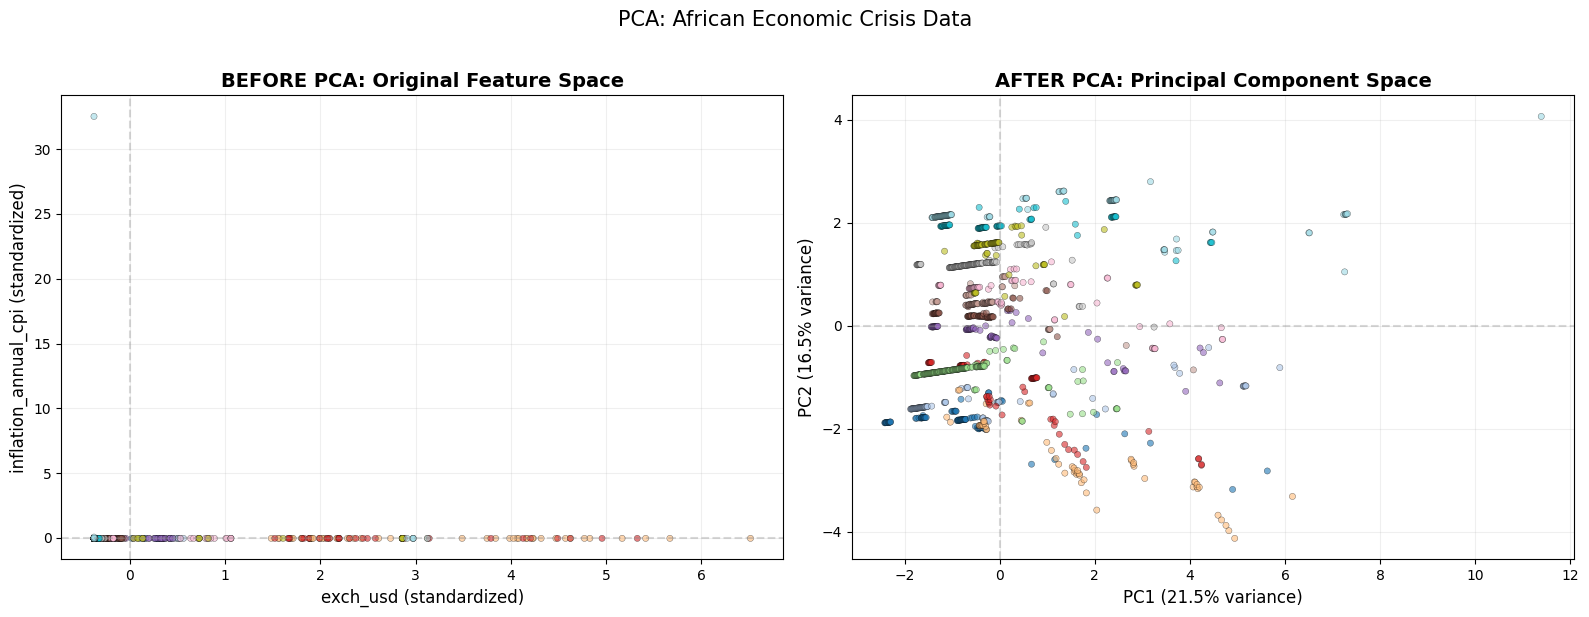

Points before: 1059
Points after: 1059
-> Same number of data points preserved


In [10]:
# Step 8: Visualize Before and After PCA
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
country_codes = df_processed['country_encoded'].values
explained_variance_ratio = eigenvalues / np.sum(eigenvalues)

feat_x = feature_names.index('exch_usd')
feat_y = feature_names.index('inflation_annual_cpi')
axes[0].scatter(standardized_data[:, feat_x], standardized_data[:, feat_y],
    c=country_codes, cmap='tab20', alpha=0.6, s=20, edgecolors='k', linewidths=0.3)
axes[0].set_xlabel('exch_usd (standardized)', fontsize=12)
axes[0].set_ylabel('inflation_annual_cpi (standardized)', fontsize=12)
axes[0].set_title('BEFORE PCA: Original Feature Space', fontsize=14, fontweight='bold')
axes[0].axhline(y=0, color='gray', linestyle='--', alpha=0.3)
axes[0].axvline(x=0, color='gray', linestyle='--', alpha=0.3)
axes[0].grid(True, alpha=0.2)

axes[1].scatter(reduced_data[:, 0], reduced_data[:, 1],
    c=country_codes, cmap='tab20', alpha=0.6, s=20, edgecolors='k', linewidths=0.3)
axes[1].set_xlabel(f'PC1 ({explained_variance_ratio[0]*100:.1f}% variance)', fontsize=12)
axes[1].set_ylabel(f'PC2 ({explained_variance_ratio[1]*100:.1f}% variance)', fontsize=12)
axes[1].set_title('AFTER PCA: Principal Component Space', fontsize=14, fontweight='bold')
axes[1].axhline(y=0, color='gray', linestyle='--', alpha=0.3)
axes[1].axvline(x=0, color='gray', linestyle='--', alpha=0.3)
axes[1].grid(True, alpha=0.2)

plt.suptitle('PCA: African Economic Crisis Data', fontsize=15, y=1.02)
plt.tight_layout()
plt.show()
print(f"Points before: {standardized_data.shape[0]}")
print(f"Points after: {reduced_data.shape[0]}")
print("-> Same number of data points preserved")

## Explanation of PCA effects (What changed after PCA)

1. **Before PCA** — We plotted just 2 out of 13 features (exchange rate and inflation). This only shows a small slice of the data, which is why most points are squished together.
2. **After PCA** — PC1 and PC2 are new axes built from ALL 13 features combined. This spreads the data out more, making patterns easier to see.
3. **Same data points** — Both plots have exactly 1059 points. PCA doesn't add or remove data, it just looks at it from a better angle.
4. **Countries still group together** — The colors show that countries with similar economies stay near each other in both plots. PCA preserves these relationships.
5. **Fewer dimensions** — We reduced 13 features down to just 2, while keeping 38% of the total information. To keep 90%, we would need 9 components.

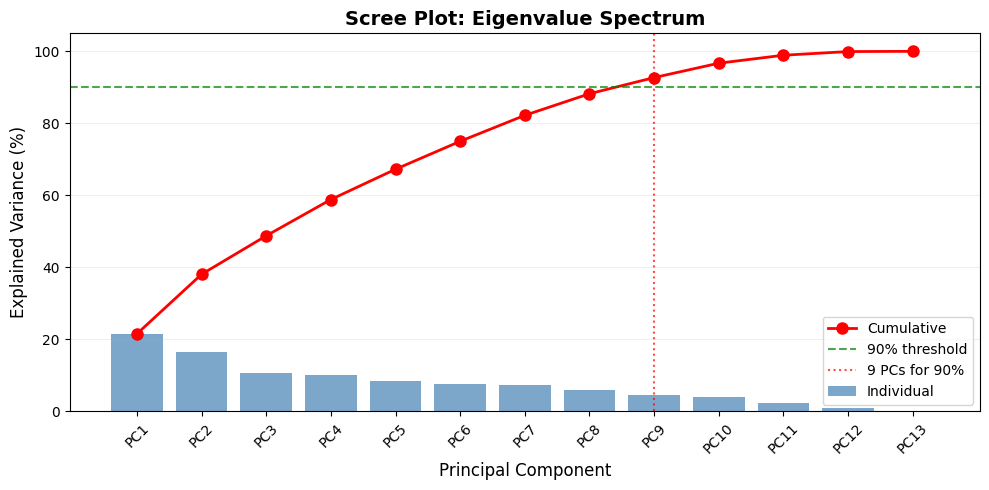

Components needed for 90% variance: 9
Components needed for 95% variance: 10


In [11]:
# Scree Plot
fig, ax = plt.subplots(figsize=(10, 5))
x = range(1, len(eigenvalues) + 1)
cumulative_variance = np.cumsum(explained_variance_ratio)

ax.bar(x, explained_variance_ratio * 100, color='steelblue', alpha=0.7, label="Individual")
ax.plot(x, cumulative_variance * 100, 'ro-', linewidth=2, markersize=8, label='Cumulative')
ax.axhline(y=90, color='green', linestyle='--', alpha=0.7, label='90% threshold')
n_90 = np.argmax(cumulative_variance >= 0.90) + 1
ax.axvline(x=n_90, color='red', linestyle=':', alpha=0.7, label=f'{n_90} PCs for 90%')
ax.set_xlabel('Principal Component', fontsize=12)
ax.set_ylabel('Explained Variance (%)', fontsize=12)
ax.set_title('Scree Plot: Eigenvalue Spectrum', fontsize=14, fontweight='bold')
ax.set_xticks(list(x))
ax.set_xticklabels([f'PC{i}' for i in x], rotation=45)
ax.legend()
ax.grid(True, alpha=0.2, axis='y')
plt.tight_layout()
plt.show()
print(f"Components needed for 90% variance: {n_90}")
print(f"Components needed for 95% variance: {np.argmax(cumulative_variance >= 0.95) + 1}")

In [12]:
# Dynamic principal component selection
def select_components_dynamic(eigenvalues, threshold=0.90):
    """Select minimum PCs needed to reach the variance threshold."""
    total = np.sum(eigenvalues)
    ratios = eigenvalues / total
    cumulative = np.cumsum(ratios)
    n_components = np.argmax(cumulative >= threshold) + 1
    return n_components, cumulative[n_components - 1]

print("DYNAMIC COMPONENT SELECTION")
print("=" * 50)
for thresh in [0.80, 0.85, 0.90, 0.95, 0.99]:
    n, var = select_components_dynamic(eigenvalues, thresh)
    print(f"Threshold {thresh*100:.0f}% -> {n} PCs (actual: {var*100:.2f}%)")

n_optimal, var_retained = select_components_dynamic(eigenvalues, 0.90)
V_optimal = sorted_eigenvectors[:, :n_optimal]
X_pca_optimal = standardized_data @ V_optimal

print(f"\nOptimal components (90%): {n_optimal}")
print(f"Dimension reduction: {standardized_data.shape[1]} -> {n_optimal} features")
print(f"Compression ratio: {standardized_data.shape[1] / n_optimal:.1f}x")

DYNAMIC COMPONENT SELECTION
Threshold 80% -> 7 PCs (actual: 82.23%)
Threshold 85% -> 8 PCs (actual: 88.23%)
Threshold 90% -> 9 PCs (actual: 92.71%)
Threshold 95% -> 10 PCs (actual: 96.71%)
Threshold 99% -> 12 PCs (actual: 99.94%)

Optimal components (90%): 9
Dimension reduction: 13 -> 9 features
Compression ratio: 1.4x


BENCHMARK: PCA Runtime vs Dataset Size
n=     100 samples -> 0.78 ms
n=     500 samples -> 1.00 ms
n=   1,000 samples -> 0.47 ms
n=   5,000 samples -> 1.53 ms
n=  10,000 samples -> 2.73 ms
n=  50,000 samples -> 21.62 ms
n= 100,000 samples -> 54.96 ms

BENCHMARK: PCA Runtime vs Feature Count (n=5000)
features=   5 -> 1.29 ms
features=  10 -> 1.88 ms
features=  20 -> 2.79 ms
features=  50 -> 7.57 ms
features= 100 -> 13.65 ms
features= 200 -> 33.52 ms


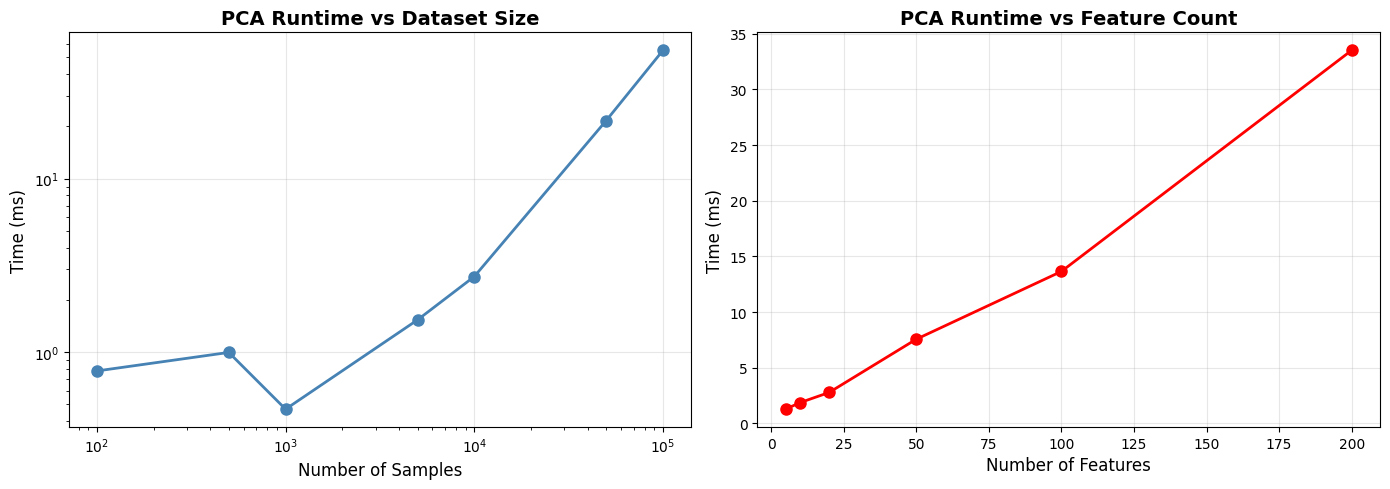

Runtime complexity: O(n*d^2)
  - Covariance computation dominates for large n (samples)
  - Eigendecomposition dominates for large d (features)


In [13]:
# Performance Benchmarking
def pca_from_scratch(X, n_components=2):
    """Complete PCA pipeline in one function."""
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0, ddof=0)
    std[std == 0] = 1.0
    X_std = (X - mean) / std
    cov = (1 / X_std.shape[0]) * (X_std.T @ X_std)
    eigvals, eigvecs = np.linalg.eigh(cov)
    idx = np.argsort(eigvals)[::-1]
    eigvecs = eigvecs[:, idx]
    return X_std @ eigvecs[:, :n_components]

print("BENCHMARK: PCA Runtime vs Dataset Size")
print("=" * 50)
sizes = [100, 500, 1000, 5000, 10000, 50000, 100000]
bench_results = []
for n in sizes:
    X_bench = np.random.randn(n, 13)
    times = []
    for _ in range(3):
        start = time.time()
        pca_from_scratch(X_bench)
        times.append(time.time() - start)
    avg = np.mean(times)
    bench_results.append({'n': n, 'ms': avg * 1000})
    print(f"n={n:>8,} samples -> {avg*1000:.2f} ms")

print(f"\nBENCHMARK: PCA Runtime vs Feature Count (n=5000)")
print("=" * 55)
feat_results = []
for nf in [5, 10, 20, 50, 100, 200]:
    X_bench = np.random.randn(5000, nf)
    times = []
    for _ in range(3):
        start = time.time()
        pca_from_scratch(X_bench, n_components=min(2, nf))
        times.append(time.time() - start)
    avg = np.mean(times)
    feat_results.append({'nf': nf, 'ms': avg * 1000})
    print(f"features={nf:>4} -> {avg*1000:.2f} ms")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot([r['n'] for r in bench_results], [r['ms'] for r in bench_results], 'o-', color='steelblue', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Samples', fontsize=12)
axes[0].set_ylabel('Time (ms)', fontsize=12)
axes[0].set_title('PCA Runtime vs Dataset Size', fontsize=14, fontweight='bold')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].grid(True, alpha=0.3)

axes[1].plot([r['nf'] for r in feat_results], [r['ms'] for r in feat_results], 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Features', fontsize=12)
axes[1].set_ylabel('Time (ms)', fontsize=12)
axes[1].set_title('PCA Runtime vs Feature Count', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
print("Runtime complexity: O(n*d^2)")
print("  - Covariance computation dominates for large n (samples)")
print("  - Eigendecomposition dominates for large d (features)")